In [119]:
from tensorflow.test import is_built_with_cuda
from tensorflow.config import list_physical_devices
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

# display setup
plt.style.use("seaborn-v0_8") # for plots

In [120]:
print(is_built_with_cuda())
print(f"GPUs Available: {list_physical_devices('GPU')}")

True
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [121]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

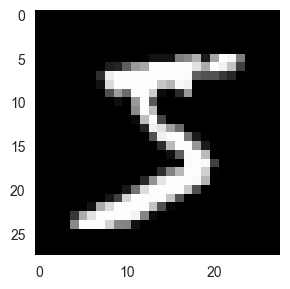

In [122]:
plt.figure(figsize=(3, 3))
plt.imshow(X_train_full[0], cmap='gray')
plt.grid(False)
plt.tight_layout()
plt.show()

In [107]:
y_train_full[0]

5

In [95]:
X_train_full.shape

(60000, 28, 28)

In [96]:
X_train_full.dtype

dtype('uint8')

In [97]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# y_valid = keras.utils.to_categorical(y_valid, num_classes=10)
# y_train = keras.utils.to_categorical(y_train, num_classes=10)

In [98]:
y_valid[0]

5

# Summary of Network Details (pg. 11-12 in the article)
## ResNet18s:
* Kernel size: 7x7, stride: 2
* Activation: ReLU
* Filters (per layer): 64, 64, 128, 256
* Weights: Xavier/Glorot initialization
* Epochs: 90
* Batch size (default): 256
* Learning rate (default): 1, decay by a factor of 10 in epochs 30, 60, 80
* Optimizer: SGD with 0.9 momentum
* Regularizers: Batch normalization, data augmentation, random cropping and flipping, 0.0001 weight decay.

## Inception-v3s:
* Kernel size:
* Activation:
* Filters (per layer):
* Weights: Truncated normal 0.1,
* Epochs: 90
* Batch size (default): 256
* Learning rate (default): 1, exponential decay by 4% every 8 epochs
* Optimizer: RMSProp
* Regularizers: Weight decay 0.00004, augmentation with random cropping and flipping,
    batch norm 0.9997 decay with epsilon 0.001 (avoid division by zero)

## AlexNets:
5 layers: 2 convolutional, 2 dense, 1 output layer
* Kernel size: 5x5, stride 1
* Max pooling: 3x3, stride 2 (local response normalization after each pooling- see article for exact params.
* Activation: ReLU
* Filters (per layer): 1x Size Model: convolutions 96 and 256 filters, dense 384 and 192 units.
* Weights: Xavier/Glorot initialization
* Batch size (default): 128
* Learning rate (default): 0.01, exponential decay by 5% every epoch
* Optimizer: SGD with 0.9 momentum
* Regularizers: None

## ResNet56s:
Convolutional layers 16, 16, 32, 64, 128 filters
* Kernel size: 3x3, stride 1
* Activation: ReLU
* Filters (per layer):
* Weights: Xavier/Glorot initialization
* Epochs: 182
* Batch size (default): 128
* Learning rate (default): 1, decay factor 10 at epochs 91 and 136
* Optimizer: SGD with 0.9 momentum
* Regularizers: Batch normalization, data augmentation with random cropping and flipping
    (except for randomly labeled data variants), 0.0002 weight decay.

## MLP:
* Size: Single hidden layer with 128 units + bias and binary output
* Activation: ReLU
* Weights: Normal distribution with std 0.01.
* Epochs (default): 50
* Batch size (default): 128

# First Model: CNN

In [99]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=24,
                        kernel_size=5,
                        padding='valid',
                        activation='relu',
                        input_shape=(28, 28, 1),
                        kernel_initializer="glorot_uniform"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # output layer
])

In [100]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4824 - accuracy: 0.8672 - val_loss: 0.2197 - val_accuracy: 0.9358

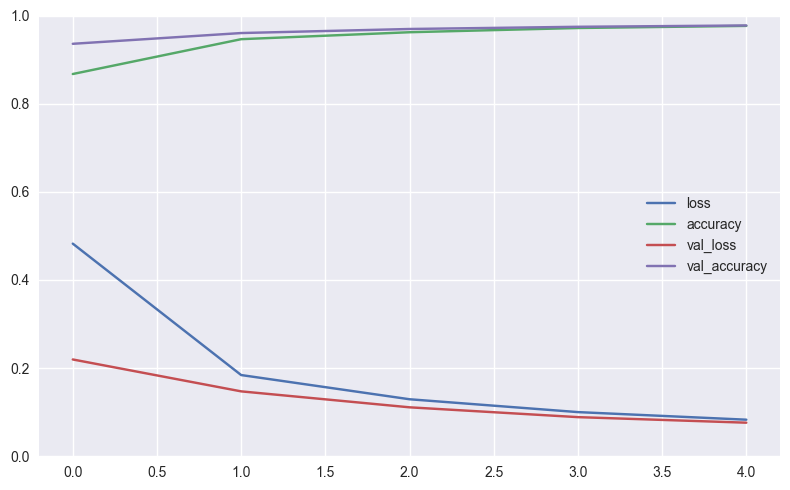

In [123]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [102]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 2.3083 - accuracy: 0.1062

[2.3082947731018066, 0.10620000213384628]